### Importing all the required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers
!pip install Afinn

In [ ]:
import math
import numpy as np
import pandas as pd
import nltk
import string
import re
import scipy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from transformers import pipeline
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from afinn import Afinn
import matplotlib.pyplot as plt
import pylab as plot
import seaborn as sn
import joblib
import warnings
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from tqdm import tqdm_notebook, tqdm
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('omw-1.4')
import gc
from scipy.sparse import hstack
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Importing the Train dataset & Train-Cross Splitting

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/train.tsv', sep='\t')
#Test set is already present as test.csv
df_train, df_cval = train_test_split(df_train, test_size = 0.25, random_state = 21)
print(df_train.shape)
print(df_cval.shape)
#Skip the blank check because in EDA as it is found that there is no blank fields
print(df_train.isna().sum())

(1111901, 8)
(370634, 8)
train_id                  0
name                      0
item_condition_id         0
category_name          4704
brand_name           474625
price                     0
shipping                  0
item_description          2
dtype: int64


## Data Pre-processing

### 1. Creating a log transform function to transform price


In [ ]:
#Apply log to numeric fields
def log_transform():
    '''  
    Description -> Applies log(1+x) function on the price column of the global variable train dataframe
    '''
    #df_train['log_price'] = np.log(df_train['price']+1)
    #df_cval['log_price'] = np.log(df_cval['price']+1)
    #Optimized way:
    df_train['log_price'] = np.log1p(df_train['price'])
    df_cval['log_price'] = np.log1p(df_cval['price'])


In [ ]:
log_transform()

### 2. Dealing with Null values

In [ ]:
def replace_with_blanks_missing():
    '''
    Description -> Interchanges the null values of the text columns with blanks in the 
                   global train and cross validation dataframe using finllna and the regex commands
    '''
    df_train.fillna('', inplace=True)
    df_cval.fillna('', inplace=True)

    df_train['item_description'] = df_train['item_description'].str.replace('^no description yet$', '', regex=True)
    df_cval['item_description'] = df_cval['item_description'].str.replace('^no description yet$', '', regex=True)

In [ ]:
replace_with_blanks_missing()

In [ ]:
print(df_train.shape)
print(df_cval.shape)
#Skip the blank check because in EDA as it is found that there is no blank fields
print(df_train.isna().sum())

(1111901, 9)
(370634, 9)
train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
log_price            0
dtype: int64


### 3. Limiting the price in specfic range as defined in mercai website


In [ ]:
#Limit price range
# Reference : https://www.kaggle.com/c/mercari-price-suggestion-challenge/discussion/45084
'''
  Description -> Removes all the invalid prices and puts the price column of the global train and cross validation
                dataframe in a reasonable valid price bound 
'''
print(str(df_train['price'].min()) , '--' , str(df_train['price'].max()))
print(str(df_cval['price'].min()), '--', str(df_cval['price'].max()))
df_train = df_train[(df_train['price'] >= 3) & (df_train['price'] <= 2000)]
df_cval = df_cval[(df_cval['price'] >= 3) & (df_cval['price'] <= 2000)]
print(str(df_train['price'].min()), '--', str(df_train['price'].max()))
print(str(df_cval['price'].min()), '--', str(df_cval['price'].max()))

0.0 -- 2009.0
0.0 -- 1900.0
3.0 -- 2000.0
3.0 -- 1900.0


In [ ]:
print(df_train.shape)
print(df_cval.shape)

(1111234, 9)
(370424, 9)


### 4. Concatinating features to create Text vector. Inspired from winner's solution to improve the score


In [ ]:
#Reference: https://www.kaggle.com/c/mercari-price-suggestion-challenge/discussion/50256
# https://github.com/divyanshjain19/Mercari_Price_Suggestion/blob/master/2_Preprocessing_and_featurizations.ipynb
df_train['name'] = df_train['name'] + " " + df_train['brand_name']
df_train['text'] = df_train['item_description'] + " " + df_train['name'] + " " + df_train['category_name']

df_cval['name'] = df_cval['name'] + " " + df_cval['brand_name']
df_cval['text'] = df_cval['item_description'] + " " + df_cval['name'] + " " + df_cval['category_name']

### 5. Converting the text data to make it more applicable for the text analysis

In [ ]:
#clean data
#Reference : Applied AI - Donar Choice Assignment
def decontracted(phrase):
    '''
    Description -> Replaces the short form words to their decontracted form such as won't to will not, 
                   this is done to make the text data uniform using regex commands.
    '''
    phrase = re.sub(r"aren\'t", "are not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"won\'t", "would not", phrase)
    phrase = re.sub(r"wouldn\'t", "would not", phrase)
    phrase = re.sub(r"haven\'t", "have not", phrase)
    phrase = re.sub(r"shouldn\'t", "should not", phrase)
    phrase = re.sub(r"doesn\'t", "does not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"mustn\'t", "must not", phrase)
    phrase = re.sub(r"needn\'t", "need not", phrase)
    return phrase

In [ ]:
df_train['name'] = df_train['name'].apply(lambda x : decontracted(x))
df_train['text'] = df_train['text'].apply(lambda x : decontracted(x))

df_cval['name'] = df_cval['name'].apply(lambda x : decontracted(x))
df_cval['text'] = df_cval['text'].apply(lambda x : decontracted(x))

### 6. Removal of special characters & emoticons

In [ ]:
#Reference : https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def deEmojify(text):
    '''
    Description -> Removes emojis, special characters as well as symbols from the input text data in order
                   to make it more apt for the analysers and returns it.    
    '''
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

### 7. Performing lemmatization

In [ ]:
#Reference: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
#Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item
def perform_lemma(sent,all_stopwords):
    '''
    Description -> Applying wordnet lemmatizer on the input sentence and returning the nearest base word/sentence.
    '''    
    sent_list = sent.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in sent_list if word not in all_stopwords]
    sent = " ".join(text)
    return sent

### 7. Final overall function pre-processing the text data

In [ ]:
regex_special_chars = re.compile('[^A-Za-z0-9.]+')
regex_decimal_digits = re.compile('(?<!\d)\.(?!\d)')
regex_white_space = re.compile(r'\s+')

# Since considering positive and negative emotion of buyer, so considering negative words also
# Reference : https://stackabuse.com/removing-stop-words-from-strings-in-python/
# all_stopwords = stopwords.words('english')
# all_stopwords.remove('not')
# all_stopwords.remove('nor')
# all_stopwords.remove('no')
#optimized way
all_stopwords = set(stopwords.words("english")) - {"no", "nor", "not"} 


def process_text_data(sent):
    '''
    Description -> Calling the demojify and lemmatization functions one by one with data as the input
                  and returning the final preprocessed data.
    '''
    
    #Removing new line, carriage return, double quotes
    sent = sent.replace('\\r', ' ')
    #sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    #remove enojis  https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    #sent = deEmojify(sent)

    #removing all special charecter except mentioned in regex strings    
    sent = regex_special_chars.sub(' ', sent)

    #removing all digit mentioned in regex strings
    sent = regex_decimal_digits.sub(' ', sent)
    
    # removing all white spaces  https://bobbyhadz.com/blog/python-remove-whitespace-regex      
    sent = regex_white_space.sub(' ', sent)
    #sent = re.sub(r'^\s+', '', sent, flags=re.MULTILINE)

    #removing end space and converting to lower
    sent = sent.strip().lower()

    # only take the words which are not stop words
    sent = perform_lemma(sent, all_stopwords)    
    return sent

In [ ]:
df_train['name'] = df_train['name'].apply(lambda x : process_text_data(x))
df_train['text'] = df_train['text'].apply(lambda x : process_text_data(x))

df_cval['name'] = df_cval['name'].apply(lambda x : process_text_data(x))
df_cval['text'] = df_cval['text'].apply(lambda x : process_text_data(x))

### 8. From EDA it is known that the length is an important feature so adding that in the dataframe

In [ ]:
df_train['length_combined_text'] = df_train['text'].str.len()
df_cval['length_combined_text']    = df_cval['text'].str.len()

## Feature engineering

### 1. Generating derived features(Price Statistics)

In [ ]:
#Reference: https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
#create derived features for prices
def create_derived_features_for_price():    
    '''
    Description -> Generating derived features using different kinds of statisical methods on the price feature
                   and then returning a dataframe containing these new features.
    
    '''
    #Reference: https://www.learndatasci.com/glossary/chebyshevs-inequality/
    #Since the mean and variance is finite but the distribution is not exactly gaussian, confirmed from EDA, so would be applying chebyshevs-inequality
    chebyshevs_kval = 2 #may be this value, could be later modified at the time of model performance improvement

    stats_price_df_train = df_train.groupby(['category_name',
                                      'brand_name',
                                      'shipping',
                                      'item_condition_id']).agg({'log_price': [np.median,np.mean, np.std]})

    stats_price_df_train.columns = ['log_price_median', 'log_price_mean' , 'log_price_std_dev']
    #stats_price_df_train['log_price_median'] = stats_price_df_train['log_price_median'].fillna(0)
    #stats_price_df_train['log_price_mean'] = stats_price_df_train['log_price_mean'].fillna(0)
    stats_price_df_train['log_price_std_dev'] = stats_price_df_train['log_price_std_dev'].fillna(0)
    stats_price_df_train['log_price_coeff_variance'] = stats_price_df_train['log_price_std_dev'] / stats_price_df_train['log_price_mean']
    stats_price_df_train['log_price_coeff_variance'].fillna(0, inplace=True)
    #68-95-97 rule modified to chebyshevs-inequality
    stats_price_df_train['log_price_min_expected'] = (stats_price_df_train['log_price_median'] - stats_price_df_train['log_price_std_dev'] * chebyshevs_kval).clip(lower=1.0)
    stats_price_df_train['log_price_max_expected_log_price'] = (stats_price_df_train['log_price_median'] + stats_price_df_train['log_price_std_dev'] * chebyshevs_kval)

    stats_price_df_cval = df_cval.groupby(['category_name',
                                      'brand_name',
                                      'shipping',
                                      'item_condition_id']).agg({'log_price': [np.median,np.mean, np.std]})

    stats_price_df_cval.columns = ['log_price_median', 'log_price_mean' ,  'log_price_std_dev']
    #stats_price_df_cval['log_price_median'] = stats_price_df_cval['log_price_median'].fillna(0)
    #stats_price_df_cval['log_price_mean'] = stats_price_df_cval['log_price_mean'].fillna(0)
    stats_price_df_cval['log_price_std_dev'] = stats_price_df_cval['log_price_std_dev'].fillna(0)
    stats_price_df_cval['log_price_coeff_variance'] = stats_price_df_cval['log_price_std_dev'] / stats_price_df_cval['log_price_mean']
    stats_price_df_cval['log_price_coeff_variance'].fillna(0, inplace=True)
    #68-95-97 rule modified to chebyshevs-inequality
    stats_price_df_cval['log_price_min_expected'] = (stats_price_df_cval['log_price_median'] - stats_price_df_cval['log_price_std_dev'] * chebyshevs_kval).clip(lower=1.0)
    stats_price_df_cval['log_price_max_expected_log_price'] = (stats_price_df_cval['log_price_median'] + stats_price_df_cval['log_price_std_dev'] * chebyshevs_kval)
    
    return stats_price_df_train,stats_price_df_cval

### 2. Applying different types of text encoders on different kinds of text data 

In [ ]:
# Currently below code is not used in featurization and same code is copied to Training Notebook
# Earlier I was calculating tfidf in featurization and saving the hstack for training. 
# But I was overall score was falling, therefore I moved the same code in training perform the vectorization before training in training notebook
# Reference Applied AI Course - Amazon Food Review Assignment/Notebook
# https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/

def text_encoder(training,cross_validation,type,params):
    '''
    Description -> Encoding different types of input text data according to its requirements using Countvectorizer
                   & Tfidfvectorizer and returning the transformed data as output
    '''
    if(type == "BOW"):
        vectorizer = CountVectorizer(ngram_range = params[0],min_df = params[1],max_df = params[2],max_features = params[3])
    elif(type == "TFIDF"):
        N_GRAMS =params
        vectorizer = vectorizer = TfidfVectorizer(max_features = 100000,
                                 ngram_range = (1, N_GRAMS),
                                 strip_accents = 'unicode',
                                 analyzer = 'word',
                                 token_pattern = r'\w+')
    elif(type=="CNTVECT"):
        vectorizer = CountVectorizer(vocabulary=params, lowercase=False, binary=True)

    train_transform = vectorizer.fit_transform(training)
    cv_transform = vectorizer.transform(cross_validation) 

    if (type == "BOW"):
        return train_transform, cv_transform, ''
    elif (type == "CNTVECT"):
        return train_transform, cv_transform, ''
    elif (type == "TFIDF"):
        feat_names = vectorizer.get_feature_names_out()
        del vectorizer
        gc.collect()
        return train_transform, cv_transform, feat_names


In [ ]:
X_train_name, X_cval_name,_ = text_encoder(df_train['name'], df_cval['name'], "TFIDF", 1)
X_train_text, X_cval_text,_ = text_encoder(df_train['text'], df_cval['text'], "TFIDF", 2)

In [ ]:
print(X_train_name.shape)
print(X_train_text.shape)
print(X_cval_name.shape)
print(X_cval_text.shape)

(1111234, 85394)
(1111234, 100000)
(370424, 85394)
(370424, 100000)


In [ ]:
def one_hot_encoder(train_data, cval_data):
    ohe_encoder = OneHotEncoder()
    train_ohe = ohe_encoder.fit_transform(train_data)
    cval_ohe = ohe_encoder.transform(cval_data)
    return train_ohe, cval_ohe

In [ ]:
X_train_shipping, X_cval_shipping = one_hot_encoder(np.reshape(df_train['shipping'].values, (-1, 1)), np.reshape(df_cval['shipping'].values, (-1, 1)))
X_train_item_condition, X_cval_item_condition = one_hot_encoder(np.reshape(df_train['item_condition_id'].values, (-1, 1)), np.reshape(df_cval['item_condition_id'].values, (-1, 1)))

In [ ]:
print(X_train_shipping.shape)
print(X_cval_shipping.shape)
print(X_train_item_condition.shape)
print(X_cval_item_condition.shape)

(1111234, 2)
(370424, 2)
(1111234, 5)
(370424, 5)


In [ ]:
trainframe = hstack((X_train_name,
                  X_train_text,
                  X_train_shipping,
                  X_train_item_condition)).tocsr().astype('float32')

cvalframe   = hstack((X_cval_name,
                 X_cval_text,
                 X_cval_shipping,
                 X_cval_item_condition)).tocsr().astype('float32')

In [ ]:
print(trainframe.shape)
print(cvalframe.shape)

(1111234, 185401)
(370424, 185401)


### 3. Sentiment score generation using VADER

In [ ]:
def generate_sentiment_scores(data):
    '''
    Description -> Calculating the sentiment score of each sentence in the input dataframe column using VADER
                   and returning 4 lists each containing a type of score calculated.
    '''
    sid = SentimentIntensityAnalyzer()
    scores_negative = []
    scores_positive = []
    scores_neutral = []
    scores_compound = []
    for sentence in tqdm(data):
        sentence_sentiment_score = sid.polarity_scores(sentence)
        scores_negative.append(sentence_sentiment_score['neg'])
        scores_positive.append(sentence_sentiment_score['neu'])
        scores_neutral.append(sentence_sentiment_score['pos'])
        scores_compound.append(sentence_sentiment_score['compound'])
    return scores_negative,scores_positive,scores_neutral,scores_compound

### 4. Sentiment score generation using Affin

In [ ]:
def generate_sentiment_scores_affin(data):
    '''
    Description -> Calculating the sentiment score of each sentence in the input dataframe column using Affin
                   and returning a list containing the score calculated.
    '''
    af = Afinn()
    scores = []
    for sentence in tqdm(data):
        sentence_sentiment_score =af.score(sentence)
        scores.append(sentence_sentiment_score)
    return scores

### 5. Sentiment score generation using BERT (not used)

In [ ]:
def generate_sentiment_scores_bert(data):    
    '''
    Description -> Calculating the sentiment score and label(Positive=1 & Negative=0) of each sentence in the 
                   input dataframe column using BERT and returning it in form of 2 lists.
    '''
    classifier = pipeline('sentiment-analysis')
    scores_score = []
    scores_label = []
    for sentence in tqdm(data):
        c=classifier(sentence)
        sentence_sentiment_score =round(c[0]['score'],4)
        sentence_sentiment_label = c[0]['label']
        scores_score.append(sentence_sentiment_score)        
        if sentence_sentiment_label is 'POSITIVE':            
            scores_label.append(1)
        else:
            scores_label.append(0)
    return scores_score,scores_label

### 6. Sentiment score generation using TextBlob

In [ ]:
def generate_sentiment_scores_textblob(data):
    '''
    Description -> Calculating the sentiment polarity(positive or negative) and subjectivity(elaborate or concise) 
                   of each sentence in the input dataframe column using TextBlob and returning it in 
                   form of 2 lists.
    '''    
    scores_score = []
    scores_subj = []
    for sentence in tqdm(data):        
        score = TextBlob(sentence)
        scores_score.append(score.sentiment.polarity)
        scores_subj.append(score.sentiment.subjectivity)
    return scores_score,scores_subj

### 6. Calling all the functions and applying them to the dataframe

In [ ]:
new=create_derived_features_for_price()
df_train=df_train.merge(new[0].reset_index(),how='left',on=['category_name', 'brand_name', 'shipping', 'item_condition_id'])


In [ ]:
df_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log_price', 'text',
       'length_combined_text', 'log_price_median', 'log_price_mean',
       'log_price_std_dev', 'log_price_coeff_variance',
       'log_price_min_expected', 'log_price_max_expected_log_price'],
      dtype='object')

### 7. Cross validation price statistics

In [ ]:
df_cval=df_cval.merge(new[1].reset_index(),how='left',on=['category_name', 'brand_name', 'shipping', 'item_condition_id'])

In [ ]:
df_cval.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log_price', 'text',
       'length_combined_text', 'log_price_median', 'log_price_mean',
       'log_price_std_dev', 'log_price_coeff_variance',
       'log_price_min_expected', 'log_price_max_expected_log_price'],
      dtype='object')

In [ ]:
print(df_train.shape)
print(df_cval.shape)
print(df_train.isna().sum())

(1111234, 17)
(370424, 17)
train_id                            0
name                                0
item_condition_id                   0
category_name                       0
brand_name                          0
price                               0
shipping                            0
item_description                    0
log_price                           0
text                                0
length_combined_text                0
log_price_median                    0
log_price_mean                      0
log_price_std_dev                   0
log_price_coeff_variance            0
log_price_min_expected              0
log_price_max_expected_log_price    0
dtype: int64


In [ ]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,text,length_combined_text,log_price_median,log_price_mean,log_price_std_dev,log_price_coeff_variance,log_price_min_expected,log_price_max_expected_log_price
0,1128032,nike crop legging nike,3,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,10.0,1,Great condition,2.397895,great condition nike crop legging nike woman a...,81,2.772589,2.853722,0.372539,0.130545,2.027510,3.517668
1,1462584,white van van,4,Women/Shoes/Fashion Sneakers,VANS,11.0,0,Stained white vans. This is how clean it gets....,2.484907,stained white van clean get no lace men 7 woma...,92,2.833213,2.826268,0.352016,0.124551,2.129182,3.537245
2,81673,2 piece outfit,1,Women/Dresses/Other,,13.0,1,Fuzzy outfit including long sleeve shirt and m...,2.639057,fuzzy outfit including long sleeve shirt mini ...,105,3.178054,3.232788,0.612515,0.189469,1.953024,4.403083
3,1412541,scrub top size large,2,Other/Daily & Travel items/Health Care,,12.0,1,Green and Navy scrub top with small hearts. On...,2.564949,green navy scrub top small heart worn not like...,167,2.708050,2.758282,0.600000,0.217527,1.508050,3.908050
4,719491,pet dry chenille hand towel,3,Home/Bath/Towels,,22.0,0,"Fluffy chenille dog, frog and sponge bob with ...",3.135494,fluffy chenille dog frog sponge bob string han...,207,2.708050,2.744043,0.451228,0.164439,1.805594,3.610506


In [ ]:
df_cval.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,text,length_combined_text,log_price_median,log_price_mean,log_price_std_dev,log_price_coeff_variance,log_price_min_expected,log_price_max_expected_log_price
0,1272357,valentine set men bath body work,1,Home/Seasonal Décor/Valentine,Bath & Body Works,12.0,1,new,2.564949,new valentine set men bath body work home seas...,64,2.564949,2.564949,0.000000,0.000000,2.564949,2.564949
1,1164265,victoria secret 32b bra victoria secret,3,Women/Underwear/Bras,Victoria's Secret,26.0,0,Everyday Bra - push up. Used condition but sti...,3.295837,everyday bra push used condition still lot lif...,195,2.833213,2.854513,0.416390,0.145871,2.000433,3.665994
2,373218,nwt slime creation kit,1,Kids/Toys/Arts & Crafts,,13.0,1,This kit makes five different kinds of slime! ...,2.639057,kit make five different kind slime look pictur...,93,1.945910,2.037993,0.536796,0.263394,1.000000,3.019502
3,1152407,toddler girl size 6 cowgirl boot,3,Kids/Girls 2T-5T/Shoes,,8.0,1,Toddler girl size 6 cowgirl boots. Good used c...,2.197225,toddler girl size 6 cowgirl boot good used con...,138,2.639057,2.665817,0.474954,0.178164,1.689150,3.588964
4,312768,boy jordan nike,4,Kids/Boys 2T-5T/Shoes,Nike,21.0,1,Used boys size 13 black Jordan's,3.091042,used boy size 13 black jordan boy jordan nike ...,64,2.636500,2.627824,0.395215,0.150396,1.846069,3.426930


### 8. Generating Sentiments scores

#### 1. Generating and adding the VADER scores in the dataframe for both original and processed text

In [ ]:
scores_negative,scores_positive,scores_neutral,scores_compound = generate_sentiment_scores(df_train['item_description_cleaned'])
df_train['senti_names_vader_negative_processed'] = scores_negative
df_train['senti_names_vader_positive_processed'] = scores_positive
df_train['senti_names_vader_neutral_processed'] = scores_neutral
df_train['senti_names_vader_compound_processed'] = scores_compound

scores_negative,scores_positive,scores_neutral,scores_compound = generate_sentiment_scores(df_train['item_description'])
df_train['senti_names_vader_negative_original'] = scores_negative
df_train['senti_names_vader_positive_original'] = scores_positive
df_train['senti_names_vader_neutral_original'] = scores_neutral
df_train['senti_names_vader_compound_original'] = scores_compound

100%|██████████| 1186028/1186028 [05:18<00:00, 3722.38it/s]


#### 2. Generating and adding the Affin scores in the dataframe for both original and processed text

In [ ]:
df_train['senti_names_affin_original'] = generate_sentiment_scores_affin(df_train['item_description'])
df_train['senti_names_affin_processed'] = generate_sentiment_scores_affin(df_train['item_description_cleaned'])

100%|██████████| 1186028/1186028 [10:08<00:00, 1949.65it/s]


#### 3. Sentiment Analysis using BERT

In [ ]:
#I was trying to implement sentiment analysis using BERT but it would take a lot of time(~20-30hrs) so instead implemented textblob for sentiment analysis
#scores,labels= generate_sentiment_scores_bert(senti_data1_original)
#df_train['senti_names_bert_score_original'] = scores
#df_train['senti_names_bert_label_original'] = labels

#scores,labels= generate_sentiment_scores_bert(senti_data1_processed)
#df_train['senti_names_bert_score_processed'] = scores
#df_train['senti_names_bert_label_processed'] = labels

### 4. Generating and adding the TextBlob scores in the dataframe for both original and processed text

In [ ]:
scores,labels= generate_sentiment_scores_textblob(df_train['item_description'])
df_train['senti_names_textblob_polarity_original'] = scores
df_train['senti_names_textblob_subjectivity_original'] = labels 

scores,labels= generate_sentiment_scores_textblob((df_train['item_description_cleaned']))
df_train['senti_names_textblob_polarity_processed'] = scores
df_train['senti_names_textblob_subjectivity_processed'] = labels

100%|██████████| 1186028/1186028 [04:01<00:00, 4908.74it/s]


In [ ]:
df_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log_price',
       'log_price_median', 'log_price_mean', 'log_price_std_dev',
       'log_price_coeff_variance', 'log_price_min_expected',
       'log_price_max_expected_log_price', 'text', 'item_description_cleaned',
       'length_combined_text', 'senti_names_vader_negative_processed',
       'senti_names_vader_positive_processed',
       'senti_names_vader_neutral_processed',
       'senti_names_vader_compound_processed',
       'senti_names_vader_negative_original',
       'senti_names_vader_positive_original',
       'senti_names_vader_neutral_original',
       'senti_names_vader_compound_original', 'senti_names_affin_original',
       'senti_names_affin_processed', 'senti_names_textblob_polarity_original',
       'senti_names_textblob_subjectivity_original',
       'senti_names_textblob_polarity_processed',
       'senti_names_textblob_subjectivity_proce

### 9. joblib storage


In [ ]:
# Storing the final train dataframe and will be modified later on during baseline modelling 
# to accommodate transformed features which are currently stored in a joblib format
joblib.dump(df_train, '/content/gdrive/MyDrive/binary_files/df_train_26Jan23_v1.joblib')

['/content/gdrive/MyDrive/binary_files/df_train_26Jan23_v1.joblib']

In [ ]:
joblib.dump(df_cval, '/content/gdrive/MyDrive/binary_files/df_cval_26Jan23_v1.joblib')

['/content/gdrive/MyDrive/binary_files/df_cval_26Jan23_v1.joblib']

In [ ]:
joblib.dump(trainframe, '/content/gdrive/MyDrive/binary_files/trainframe_26Jan23_v1.joblib')
joblib.dump(cvalframe, '/content/gdrive/MyDrive/binary_files/cvalframe_26Jan23_v1.joblib')

['/content/gdrive/MyDrive/binary_files/cvalframe_26Jan23_v1.joblib']

In [ ]:
df_train=joblib.load('/content/gdrive/MyDrive/binary_files/df_train_24Jan23_v2.joblib')

In [ ]:
len(df_train.columns)

32

### 10. Heatmap and Observations


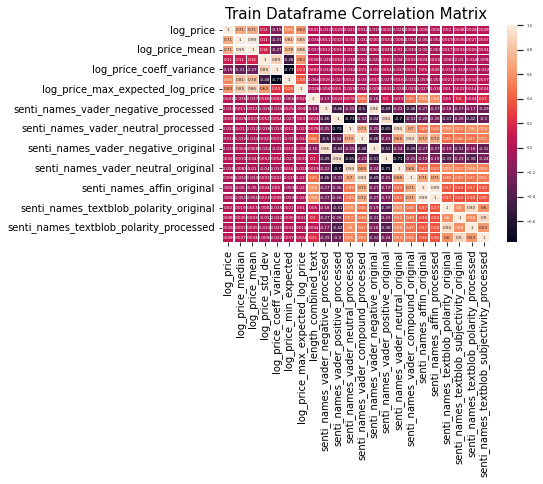

In [ ]:
df_traincorr = df_train.drop(columns = ['train_id','item_condition_id','shipping','price'])
corMat = df_traincorr.corr()
plt.title('Train Dataframe Correlation Matrix', fontsize = 15)
sns.set(font_scale=0.34)
sns.heatmap(corMat,annot=True,linewidths=0.5)
plt.show()

### Observations

1) The following features -> log_price_median, log_price_min_expected and log_price_max_expected_log_price have a high correlation with the target variable so considering to take these 3 features

2) If building a linear model will only use log_price_median as the feature

### Feature selection confirmation using SelectKBest

In [ ]:
log_price = df_train['log_price']
df_featselector = df_train.drop(columns = ['train_id','name','text','item_condition_id','category_name','brand_name','price','shipping','item_description','log_price','item_description_cleaned'])
df_featselector.columns
selector = SelectKBest(f_regression,k = "all")
selector.fit(df_featselector, log_price)
for feat,score in zip(df_featselector.columns,selector.scores_):
    print("Feature =",feat)
    print("Score =",round(score))

Feature = log_price_median
Score = 1186307
Feature = log_price_mean
Score = 1239138
Feature = log_price_std_dev
Score = 15215
Feature = log_price_coeff_variance
Score = 44987
Feature = log_price_min_expected
Score = 529126
Feature = log_price_max_expected_log_price
Score = 724503
Feature = length_combined_text
Score = 1962
Feature = senti_names_vader_negative_processed
Score = 195
Feature = senti_names_vader_positive_processed
Score = 967
Feature = senti_names_vader_neutral_processed
Score = 502
Feature = senti_names_vader_compound_processed
Score = 2
Feature = senti_names_vader_negative_original
Score = 426
Feature = senti_names_vader_positive_original
Score = 1237
Feature = senti_names_vader_neutral_original
Score = 504
Feature = senti_names_vader_compound_original
Score = 1
Feature = senti_names_affin_original
Score = 31
Feature = senti_names_affin_processed
Score = 40
Feature = senti_names_textblob_polarity_original
Score = 493
Feature = senti_names_textblob_subjectivity_original
S

### Observations

1) The heatmap observations sets to be true as seen by scores given out by using SelectKBest as a feature selector 

2) This feature would be added senti_names_textblob_subjectivity_processed to check the impact on the baseline model accuracy because there is significant difference between other sentiment features and has a higher score given by SelectKBest